# 1. Loading the Data from Google Drive
---
### 1.1 Mount Dataset

Mount the drive and extract the dataset from images separated into corresponding folders

The mounting of the drive is only necessary if the notebook is run on Google Colab instead of locally

The folder is divided into:
1. Test Folder
  * With Mask Folder
  * Without Mask Folder
2. Train Folder
  * With Mask Folder
  * Without Mask Folder
2. Validation Folder
  * With Mask Folder
  * Without Mask Folder

---
### 1.2 Import Modules

All required modules are also imported after 

These modules are:
  * Numpy
  * Matplotlib.pyplot
  * Seaborn
  * Tensorflow
  * Keras 
  * Scikit-Learn 

In [ ]:
# 1.1 
# Mounting to drive
# This step is only necessary if the notebook is run on Google Colab instead of locally

from google.colab import drive 

drive.mount("/content/gdrive") 

In [ ]:
# 1.2
# Import needed modules

# Basic packages needed for data analysis, visualization and manipulation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Mainly Tensorflow packages for data preprocessing
from PIL import Image 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical 

# Mainly Tensorflow.keras layers needed to build the Convolutional Neural Network (CNN)
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras import Sequential, regularizers

# Mainly functions to load from saved checkpoints
from tensorflow.keras.models import load_model

# Mainly Tensorflow modules that help to optimize and fine-tune the CNN models better
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import KFold, train_test_split 
from math import ceil

# Mainly metrics to assess the CNN's performance
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report

# 2. Preprocessing the data and preparing the CNN model

___

### 2.1 Prepare ImageDataGenerator
Create an ImageDataGenerator instance for data augmentation

Considering the rotation, width and height shift, brightness, shear, zoom and horizontal flipping to mimic the possible real-world data the model would face

Diversifies the dataset to let the model be trained on a larger and more diverse set of images

___

### 2.2 Construct CNN Model
The model's architecture is mainly a result of extensive experimentation, with AlexNet/ZFNet as inspirations of the starting point architecture

The activation function for the hidden layers would be ReLU whereas Sigmoid would be applied to the output layer of a single neuron

The dense layers would have dropout regularization and L2 weight regularization applied 

The optimizer used is Adam, which gives an adaptive learning rate, the loss measured is "binary cross-entropy", and early stopping and reduce LR on plateau would be implemented (loss is monitored for early stopping) 

The model is as follows: (_Refer to model summary for more info_)
  1. Fisrt Convolutional Block
    * Input convolutional layer
    * Batch normalization
    * Max pooling layer
  2. Second Convolutional Block
    * Convolutional layer
    * Convolutional layer
    * Batch normalization 
    * Max pooling layer
    * Dropout regularization
  3. Third Convolutional Block
    * Convolutional layer
    * Convolutional layer
    * Convolutional layer 
    * Max pooling layer
  4. Flatten for dense network
  5. First Dense Block
    * Dense layer
    * Dropout regularization
  6. Second Dense Block
    * Dense layer 
    * Dropout regularization
  7. Output layer 

___ 

### 2.3 Compile Model & Prepare Callbacks

Compile the model with the Adam optimizer, Binary Cross-Entropy loss and Accuracy as the measure of success

The callback objects for early stopping, saving model checkpoints and reducing LR on plateau are prepared

___

### 2.4 Loading Previous Models

Instead of fitting a model to the dataset from scratch, we can also load a model that was saved from a previous training and resume training from there

This can be done either by loading from checkpoints (CKPT format) or a saved model (HDF5 format)

If the whole model is loaded, there is no need to construct the whole model from scratch

In [ ]:
# 2.1 
# ImageDataGenerator is an iterator for data augmentation

# As the images of the dataset are quite closely zoomed onto faces already, 
# the shift range is limited to only 0.1 to prevent the faces from going out of frame

# The brightness is not altered too drastically as the model should ultimately be used in a well lit setting

# Vertical flipping is not applied as we do not expect to see upside down faces in our use cases

# Rescaling pixels to a value between 0.0 and 1.0 as a form of normalization 
# to increase training speeds, stability and comprehensiveness

target_img_size = (224, 224)

datagen_train = ImageDataGenerator(
    rotation_range=40, # Randomly rotates the image by up to 40 degrees
    width_shift_range=0.1, # Displaces the image horizontally by up to 10% of the original image size
    height_shift_range=0.1, # Displaces the image vertically by up to 10% of the original image size
    brightness_range=[0.8, 1.2], # Alters brightness by a positive 20% or negative 20% 
    shear_range=0.3, # Shears by up to 30% in the counter-clockwise direction
    zoom_range=0.2, # Randomly zooms in and out by up to 20%
    horizontal_flip=True, # Randomly flips the image horizontally
    rescale=1./255 # Rescales pixels to a float between 0 and 1
    ) 

datagen_val = ImageDataGenerator(
    rotation_range=40, # Same requirements repeated for validation dataset
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    brightness_range=[0.8, 1.2], 
    shear_range=0.3, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    rescale=1./255
    )

datagen_test = ImageDataGenerator(
    rescale=1./255 # No augmentation involved for testing dataset, just rescaling as the CNN is trained on normalized pixels
)

In [ ]:
# 2.2
# Best performing model discovered via experimentation so far, considering all limitations and conditions given
# BPFModel

# Initialize model
model = Sequential()
# First convol block
model.add(Conv2D(32, (5, 5), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.0001), input_shape=(224,224,3))) # input layer
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=2))
# Second convol block
model.add(Conv2D(64, (5, 5), strides=1, padding='valid', activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(Conv2D(64, (5, 5), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=2))
model.add(Dropout(0.4))
# Third convol block
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=regularizers.L2(0.0001)))
model.add(MaxPool2D(pool_size=(3,3), strides=2))
# Flatten layer
model.add(Flatten())
# First dense block
model.add(Dense(2000, kernel_regularizer=regularizers.L2(0.0001), activation='relu')) 
model.add(Dropout(0.4)) 
# Second dense block
model.add(Dense(2000, kernel_regularizer=regularizers.L2(0.0001), activation='relu'))
model.add(Dropout(0.4))
# Output block
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Double-checking the model 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      2432      
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 107, 107, 64)      51264     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 107, 107, 64)      102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 107, 107, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 64)       

In [ ]:
# 2.3

# Compiling the model
opt = Adam(learning_rate=1e-4) # Using the adam optimizer which allows for adapting LRs, initialized as 0.0001

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
# Binary cross-entropy used as there are 2 categories predicted by one output neuron
# Accuracy used as measure of success

# Prepare for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1)

# Prepare for model checkpoint saving
checkpoint_path = "/content/gdrive/<path to checkpoint storage>/<filename>.ckpt" 

model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

# Prepare for reduced LR when approaching a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

In [ ]:
# 2.4
# Load from a previously saved state of a trained model

# Load previously saved weights from CKPT file
model.load_weights("/content/gdrive/<path to CKPT file>/<filename>.ckpt")

# Load previously saved model from HDF5 file
# model = load_model('/content/gdrive/<path to HDF5 file>/<filename>.h5')
# If the whole model is loaded, there is no need to construct the whole model from scratch

# 3. Fitting the CNN Model

___

### 3.1 Prepare Dataset

Prepare the training, validation and testing dataset using the flow_from_directory() method of the ImageDataGenerator object

The method reads the images and yields them in batches from the corresponding folders using the filepath, batch size and target image size provided

Shuffle is meant to introduce more randomness and the seed was set to 1 as a group decision in order to standardize within the group

The images yielded may be altered according to the earlier set parameters at random

Initially, the dataset was loaded using load_img() and img_to_array() and the augmentor iterates from memory using the flow() method. 

In order to standardize the dataset used however, flow_from_directory() method is now used instead to iterate from storage instead. 

___

### 3.2 Fitting the CNN Model

The model is fitted to the dataset, using the training and validation ImageDataGenerator and the 3 callback objects prepared

The results are appended to a list called model_metadata

___

### 3.3 Load Previous Model

Instead of fitting a new model to the dataset, we can also load a model that was saved from a previous training

This can be done either by loading from checkpoints (CKPT format) or a saved model (HDF5 format)

If the whole model is loaded, there is no need to construct the whole model from scratch

___

### 3.4 Evaluation

The model's performance after fitting is then evaluated using the testing ImageDataGenerator

A confusion matrix and classification report is also plotted to observe the model's other metrics of performance

___

### 3.5 Viewing the Predictions

Using matplotlib.pyplot, we can see the image of predicted images alongside the prediction and true label

___

### 3.6 Saving Model

The model can be saved in its entirety into an HDF5 file

In [ ]:
# 3.1

# Standard batch size of 32 for time trade-off
BATCH_SIZE = 32

# Paths to corresponding dataset folders
train_path = "/content/gdrive/<path to dataset storage>/data/train" # Training dataset
val_path = "/content/gdrive/<path to dataset storage>/data/val" # Validation datset
test_path = "/content/gdrive/<path to dataset storage>/data/test" # Testing dataset

# ImageDataGenerator can directly read the dataset from disk and create batches of images that are altered at random

# Target image size is (224, 224), batch size is 32, class mode refers to the 2 classes predicted by the CNN model
# Shuffle set to True indicates that the generator would select images to alter and yield randomly from a dataset that is random shuffled
# Testing ImageDataGenerator has shuffle set to False so that the class labels used for the confusion matrix would be in the correct order

train_gen = datagen_train.flow_from_directory(train_path, target_size=target_img_size, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True, seed=1)

val_gen = datagen_val.flow_from_directory(val_path, target_size=target_img_size, batch_size=BATCH_SIZE, class_mode="binary", shuffle=True, seed=1)

test_gen = datagen_test.flow_from_directory(test_path, target_size=target_img_size, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

Found 3561 images belonging to 2 classes.
Found 1017 images belonging to 2 classes.
Found 509 images belonging to 2 classes.


In [ ]:
# 3.2
# Preparing the list to store details of the model's training performance
model_metadata = []

# Fitting the model
model_metadata.append(
    model.fit_generator(train_gen, 
              steps_per_epoch=ceil(3561/BATCH_SIZE),
              epochs=15, 
              callbacks=[early_stopping, reduce_lr, model_checkpoint],
              validation_data=val_gen,
              validation_steps=ceil(1017/BATCH_SIZE),
              verbose=1))

In [ ]:
# 3.3
# Load from a previously saved state of a trained model

# Load previously saved weights from CKPT file
model.load_weights("/content/gdrive/<path to CKPT file>/<filename>.ckpt")

# Load previously saved model from HDF5 file
# model = load_model('/content/gdrive/<path to HDF5 file>/<filename>.h5')
# If the whole model is loaded, there is no need to construct the whole model from scratch

In [ ]:
# 3.4
# Observing the results

# Use evaluate() method to evaluate performance metrics of accuracy and loss
model_metadata.append(
    model.evaluate(test_gen, verbose=1, return_dict=True)
) 

In [ ]:
# Observe the returned results of the evaluate() method
model_metadata[-1]

{'accuracy': 0.9410609006881714, 'loss': 0.6789568066596985}

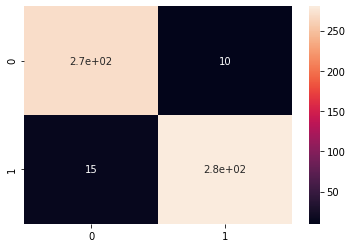

In [ ]:
# Plotting the confusion matrix 

# Getting the predictions
y_pred = model.predict(test_gen, verbose=1)
y_pred = (y_pred > 0.5).astype('int32')

# Getting the class labels
y_classes = list(test_gen.class_indices)

# Plotting the confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
sns.heatmap(cm, annot=True, xticklabels=y_classes, yticklabels=y_classes)

In [ ]:
# Scores according to different metrics

# Accuracy 
print("Accuracy: ", end="")
print(accuracy_score(test_gen.classes, y_pred))

# Recall
print("Recall: ", end="")
print(recall_score(test_gen.classes, y_pred))

# Precision 
print("Precision: ", end="")
print(precision_score(test_gen.classes, y_pred))

# F1
print("F1 score: ", end="")
print(f1_score(test_gen.classes, y_pred))

0.9565217391304348
0.9491525423728814
0.9655172413793104
0.9572649572649573


In [ ]:
# Creating the classification report

print(classification_report(test_gen.classes, y_pred, target_names=y_classes))

In [ ]:
# 3.5 
# Viewing the image and corresponding class and prediction by the model

# Getting a batch of images 
batch = test_gen.__next__()

# Getting predictions on that batch
results = model.predict(batch, verbose=1)
results = (results > 0.5).astype('int32') 

In [ ]:
# Picture to be reviewed
image = 1

# Get the true class
print(f"Correct Class: {batch[1][image]}")

# Get the predicted class
print(f"Predicted Class: {results[image]}")

# Get the image 
plt.imshow(batch[0][image])

In [ ]:
# 3.6
# Saving the model in HDF5 format

model.save('/content/gdrive/<path to location to save file to>/<filename>.h5')